In [57]:
import numpy as np
import networkx as nx
import functools as ft
import math
import random
from datasets import load_dataset

In [2]:
MUTAG = load_dataset("graphs-datasets/MUTAG")

In [3]:
def hdv(d):
    return np.random.choice([-1, 1], d)


def bind(xs):
    return ft.reduce(lambda x, y: x * y, xs)


def bundle(xs):
    return np.sign(ft.reduce(lambda x, y: x + y, xs))


def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)

    return dot_product / (norm_A * norm_B)


class ItemMemory:
    def __init__(self, vectors=[]):
        self.vectors = vectors

    def addVector(self, label, V):
        self.vectors.append((label, V))

    def count(self):
        return len(self.vectors)

    def cleanup(self, V):
        return max(self.vectors, key=lambda x: cosine_similarity(V, x[1]))

In [4]:
def encodeGraph(graph, vertices, dimensions, digits, alpha):
    gpr = nx.pagerank(graph, alpha)

    for pr in nx.pagerank(graph, alpha).values():
        key = str(round(pr, digits))
        vertices[key] = hdv(dimensions)

    Edges = []

    for edge in graph.edges:
        keyV1 = str(round(gpr[edge[0]], digits))
        keyV2 = str(round(gpr[edge[1]], digits))
        v1 = vertices[keyV1]
        v2 = vertices[keyV2]
        E = bind([v1, v2])
        Edges.append(E)

    Graph = bundle(Edges)

    return Graph

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin


class GraphHD(BaseEstimator, ClassifierMixin):
    def __init__(self, dimensions=10000, digits=7, alpha=0.85):
        self.dimensions = dimensions
        self.digits = digits
        self.alpha = alpha
        self.vertices = dict()

    def fit(self, X, y):
        self.memory = ItemMemory([])
        self.labels = list(set(y))
        dictLabels = dict()

        for label in self.labels:
            dictLabels[label] = []

        for i in range(len(y)):
            Graph = encodeGraph(
                X[i], self.vertices, self.dimensions, self.digits, self.alpha
            )
            dictLabels[y[i]].append(Graph)

        for key, value in dictLabels.items():
            Label = bundle(value)
            self.memory.addVector(str(key), Label)

        return self

    def predict(self, X):
        predictions = []
        similarities = []
        for testGraph in X:
            queryVector = encodeGraph(
                testGraph, self.vertices, self.dimensions, self.digits, self.alpha
            )
            cleanVector = self.memory.cleanup(queryVector)

            predictions.append(int(cleanVector[0]))
            similarities.append(cosine_similarity(queryVector, cleanVector[1]))

        print("%.5f" % round(np.mean(similarities), 5), predictions)
        return predictions

In [6]:
def processDataset(dataset):
    graphs = []
    labels = []

    for graph in dataset:
        G = nx.Graph()
        G.add_edges_from(zip(graph["edge_index"][0], graph["edge_index"][1]))
        graphs.append(G)
        labels.append(graph["y"][0])

    return (graphs, labels)

0
0.09151 [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
0.10491 [0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]
0.10924 [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]
0.10027 [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]
0.13089 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
0.13122 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
0.10035 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
0.11703 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
0.06659 [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
0.06177 [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
0.64912
1
0.10518 [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
0.07033 [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
0.09390 [1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
0.10047 [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
0.12907 [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]
0.13265

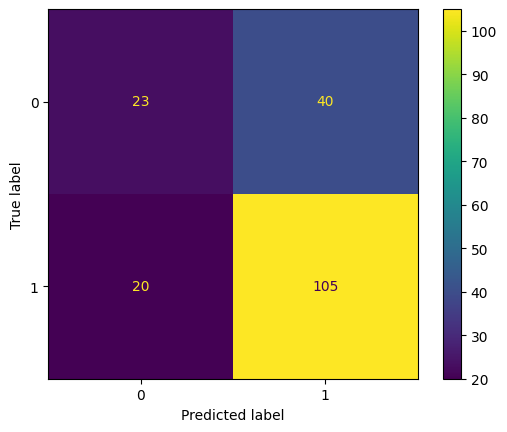

In [74]:
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

DIMENSIONS = 10000
DIGITS = 4
ALPHA = 0.45


def main():
    (graphs, labels) = processDataset(MUTAG["train"])

    sum = 0
    for i in range(10):
        print(i)
        clf = GraphHD(DIMENSIONS, DIGITS, ALPHA)

        scores = cross_val_score(clf, graphs, labels, cv=10, n_jobs=-1)
        sum += scores.mean()
        print("%.5f" % scores.mean())

    print("final score: %.5f" % (sum / 10))


def main2():
    (graphs, labels) = processDataset(MUTAG["train"])
    distributions = dict(
        dimensions=[500, 1000, 5000, 10000],
        digits=[2, 3, 4, 5, 6],
        alpha=[0.25, 0.35, 0.45, 0.55, 0.75],
    )
    clf = GridSearchCV(GraphHD(), distributions, n_jobs=-1, cv=10, verbose=1)
    search = clf.fit(graphs, labels)
    print(search.best_params_)
    print(search.best_score_)
    print(search.best_estimator_)


def main3():
    (graphs, labels) = processDataset(MUTAG["train"])
    clf = GraphHD(DIMENSIONS, DIGITS, ALPHA)
    y_pred = cross_val_predict(clf, graphs, labels, cv=10, n_jobs=-1)
    conf_mat = confusion_matrix(labels, y_pred)
    accuracy = accuracy_score(y_pred, labels)
    print(accuracy)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0, 1])
    disp.plot()
    print(conf_mat)
    plt.show()


# main()
# {'alpha': 0.45, 'digits': 4, 'dimensions': 10000} 10_iter_score: 0.65167
# {'alpha': 0.75, 'digits': 3, 'dimensions': 5000}
# {'alpha': 0.45, 'digits': 4, 'dimensions': 1000} 0.65079
# {'alpha': 0.25, 'digits': 4, 'dimensions': 1000}

# {'alpha': 0.35, 'digits': 4, 'dimensions': 1000}
# 0.7073099415204679

# {'alpha': 0.35, 'digits': 3, 'dimensions': 1000}
# 0.7131578947368421
# 10 iter 0.68120

main()
main3()